# MSA 2024 Phase 2 - Part 2

In [1]:
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Load and split preprocessed data

In [2]:
df = pd.read_csv("../0. Resources/datasets/X store sales/store_sales.csv", encoding='ISO-8859-1')
display(df.head())
display(df.info())

columns_to_describe = df.columns.drop(['Row ID', 'Postal Code'])
display(df[columns_to_describe].describe())

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
3,6,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
4,11,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2121 entries, 0 to 2120
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         2121 non-null   int64  
 1   Order ID       2121 non-null   object 
 2   Order Date     2121 non-null   object 
 3   Ship Date      2121 non-null   object 
 4   Ship Mode      2121 non-null   object 
 5   Customer ID    2121 non-null   object 
 6   Customer Name  2121 non-null   object 
 7   Segment        2121 non-null   object 
 8   Country        2121 non-null   object 
 9   City           2121 non-null   object 
 10  State          2121 non-null   object 
 11  Postal Code    2121 non-null   int64  
 12  Region         2121 non-null   object 
 13  Product ID     2121 non-null   object 
 14  Category       2121 non-null   object 
 15  Sub-Category   2121 non-null   object 
 16  Product Name   2121 non-null   object 
 17  Sales          2121 non-null   float64
 18  Quantity

None

,Sales,Quantity,Discount,Profit
count,2121.000000,2121.000000,2121.000000,2121.000000
mean,349.834887,3.785007,0.173923,8.699327
std,503.179145,2.251620,0.181547,136.049246
min,1.892000,1.000000,0.000000,-1862.312400
25%,47.040000,2.000000,0.000000,-12.849000
50%,182.220000,3.000000,0.200000,7.774800
75%,435.168000,5.000000,0.300000,33.726600
max,4416.174000,14.000000,0.700000,1013.127000


## 2. Choose an algorithm

Random Forest works by growing multiple decision trees and combining them to make more accurate predictions. The idea is that a group of uncorrelated models, which in this case are the individual decision trees, performs better together than they would on their own. In Random Forest classification, each tree gives a vote for a class, and the forest picks the class with the most votes. For regression, the forest averages the outputs of all the trees.

The strength of Random Forest comes from the low correlation between the trees. Even though individual trees might make errors, the combined result of the majority of trees will generally be correct, leading to a more accurate overall prediction.

## 3. Train and test a model

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV

df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], errors='coerce')
df['Order Year'] = df['Order Date'].dt.year
df['Order Week'] = df['Order Date'].dt.isocalendar().week
df['Week of Year'] = df['Order Date'].dt.strftime('%W').astype(int)

df_encoded = pd.get_dummies(df, columns=[
    'Order ID', 'Ship Mode', 'Customer ID', 'Customer Name', 
    'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 
    'Product ID', 'Category', 'Sub-Category', 'Product Name'
])

mean_profit = df_encoded['Profit'].mean()
std_dev_profit = df_encoded['Profit'].std()
lower_bound = mean_profit - 3 * std_dev_profit
upper_bound = mean_profit + 3 * std_dev_profit

df_no_outlier = df_encoded[(df_encoded['Profit'] >= lower_bound) & (df_encoded['Profit'] <= upper_bound)]

weekly_sales = df_no_outlier.groupby(['Order Year', 'Order Week', 'Week of Year'])['Sales'].sum().reset_index()
weekly_sales['Lagged Sales'] = weekly_sales['Sales'].shift(1)
weekly_sales = weekly_sales.dropna()
print(weekly_sales.head()) # Data is now processed.

   Order Year  Order Week  Week of Year     Sales  Lagged Sales
1        2014           2             1   138.608      3251.464
2        2014           3             2  1250.473       138.608
3        2014           4             3  1655.958      1250.473
4        2014           5             4   623.666      1655.958
5        2014           6             5    14.560       623.666


In [4]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

X = weekly_sales[['Order Year', 'Order Week', 'Week of Year', 'Lagged Sales']]
y = weekly_sales['Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#param_grid = {
    #'n_estimators': [50, 100, 200],
    #'max_depth': [10, 20, 30, None],
    #'min_samples_split': [2, 5, 10]
#}

rf = RandomForestRegressor(random_state=42)
#grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
#grid_search.fit(X_train, y_train)
#best_params = grid_search.best_params_
#print("Best parameters found by Grid Search:")
#print(best_params) - Using this way we got {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 200}, but it shows signs of overfitting so we are manually reducing the values

best_params = {'n_estimators': 100, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 10}
model = RandomForestRegressor(**best_params, random_state=42)
model.fit(X_train, y_train)

cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')

train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

train_r2 = r2_score(y_train, train_predictions)
train_rmse = mean_squared_error(y_train, train_predictions, squared=False)
train_mae = mean_absolute_error(y_train, train_predictions)

test_r2 = r2_score(y_test, test_predictions)
test_rmse = mean_squared_error(y_test, test_predictions, squared=False)
test_mae = mean_absolute_error(y_test, test_predictions)

def smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    smape_value = np.mean(numerator / denominator) * 100
    return smape_value

train_smape = smape(y_train, train_predictions)
test_smape = smape(y_test, test_predictions)

In [5]:
last_week = X.iloc[-1]
future_weeks = pd.DataFrame({
    'Order Year': [last_week['Order Year']] * 4,
    'Order Week': [last_week['Order Week'] + i for i in range(1, 5)],
    'Week of Year': [(last_week['Week of Year'] + i) % 52 for i in range(1, 5)],
    'Lagged Sales': [weekly_sales['Sales'].iloc[-1]] * 4
})
future_weeks = future_weeks[X_train.columns]
future_predictions = model.predict(future_weeks)

print("Training Set Evaluation:")
print(f"R-squared (R²): {train_r2:.2f}")
print(f"Root Mean Squared Error (RMSE): {train_rmse:.2f}")
print(f"Mean Absolute Error (MAE): {train_mae:.2f}")
print(f"Symmetric Mean Absolute Percentage Error (SMAPE): {train_smape:.2f}%")

print("\nTest Set Evaluation:")
print(f"R-squared (R²): {test_r2:.2f}")
print(f"Root Mean Squared Error (RMSE): {test_rmse:.2f}")
print(f"Mean Absolute Error (MAE): {test_mae:.2f}")
print(f"Symmetric Mean Absolute Percentage Error (SMAPE): {test_smape:.2f}%")

print("\nFuture Sales Predictions for the Next 4 Weeks:")
for i, prediction in enumerate(future_predictions, 1):
    print(f"Week {i}: {prediction:.2f}")

print("\nCross-Validation Results (R² Scores):")
print(cv_scores)
print(f"Mean R² Score: {cv_scores.mean():.2f}")

Training Set Evaluation:
R-squared (R²): 0.81
Root Mean Squared Error (RMSE): 1070.26
Mean Absolute Error (MAE): 781.86
Symmetric Mean Absolute Percentage Error (SMAPE): 34.86%

Test Set Evaluation:
R-squared (R²): 0.31
Root Mean Squared Error (RMSE): 1765.87
Mean Absolute Error (MAE): 1397.42
Symmetric Mean Absolute Percentage Error (SMAPE): 50.40%

Future Sales Predictions for the Next 4 Weeks:
Week 1: 2434.90
Week 2: 2423.04
Week 3: 2420.16
Week 4: 2400.99

Cross-Validation Results (R² Scores):
[0.17346561 0.40709209 0.27270829 0.45223916 0.49938692]
Mean R² Score: 0.36


## 4. Evaluate the model 

**Previous Model Performance**

Training Set Performance:
- The model performs well on the training set with an R² of 0.73, indicating that it explains 73% of the variance in the training data.
- The RMSE and MAE values show the model's error in terms of sales units.
- The SMAPE of 39.82% indicates that the model's predictions are relatively close to the actual values on the training set.

Test Set Performance:
- The R² value of 0.32 on the test set indicates that the model explains 32% of the variance in the test data, which suggests that there is room for improvement.
- The RMSE and MAE values are higher on the test set compared to the training set, which is expected but still indicates a performance gap.
- The SMAPE of 49.13% shows that the model's predictions are less accurate on the test set compared to the training set.

The predicted sales for the next four weeks are as below:
- Week 1: 1674.57
- Week 2: 1661.56
- Week 3: 1665.30
- Week 4: 1648.97

It is fairly stable, indicating the model's attempt to predict future sales based on past sales.

The average R² score from cross-validation indicates moderate generalization performance. The variability in R² scores across folds suggests that the model's performance can be inconsistent depending on the subset of data. The score is 0.38

**Current Model Performance**

Training Set Performance:
- The model performs well on the training set with an R² of 0.81, indicating that it explains 81% of the variance in the training data.
- The RMSE and MAE values show the model's error in terms of sales units.
- The SMAPE of 34.86% indicates that the model's predictions are relatively close to the actual values on the training set.

Test Set Performance:
- The R² value of 0.31 on the test set indicates that the model explains 31% of the variance in the test data, which suggests that there is room for improvement.
- The RMSE and MAE values are higher on the test set compared to the training set, which is expected but still indicates a performance gap.
- The SMAPE of 50.40% shows that the model's predictions are less accurate on the test set compared to the training set.

The predicted sales for the next four weeks are as below:
- Week 1: 2434.90
- Week 2: 2423.04
- Week 3: 2420.16
- Week 4: 2400.99

It is fairly stable, indicating the model's attempt to predict future sales based on past sales.

The average R² score from cross-validation indicates moderate generalization performance. The variability in R² scores across folds suggests that the model's performance can be inconsistent depending on the subset of data. The score is 0.36.

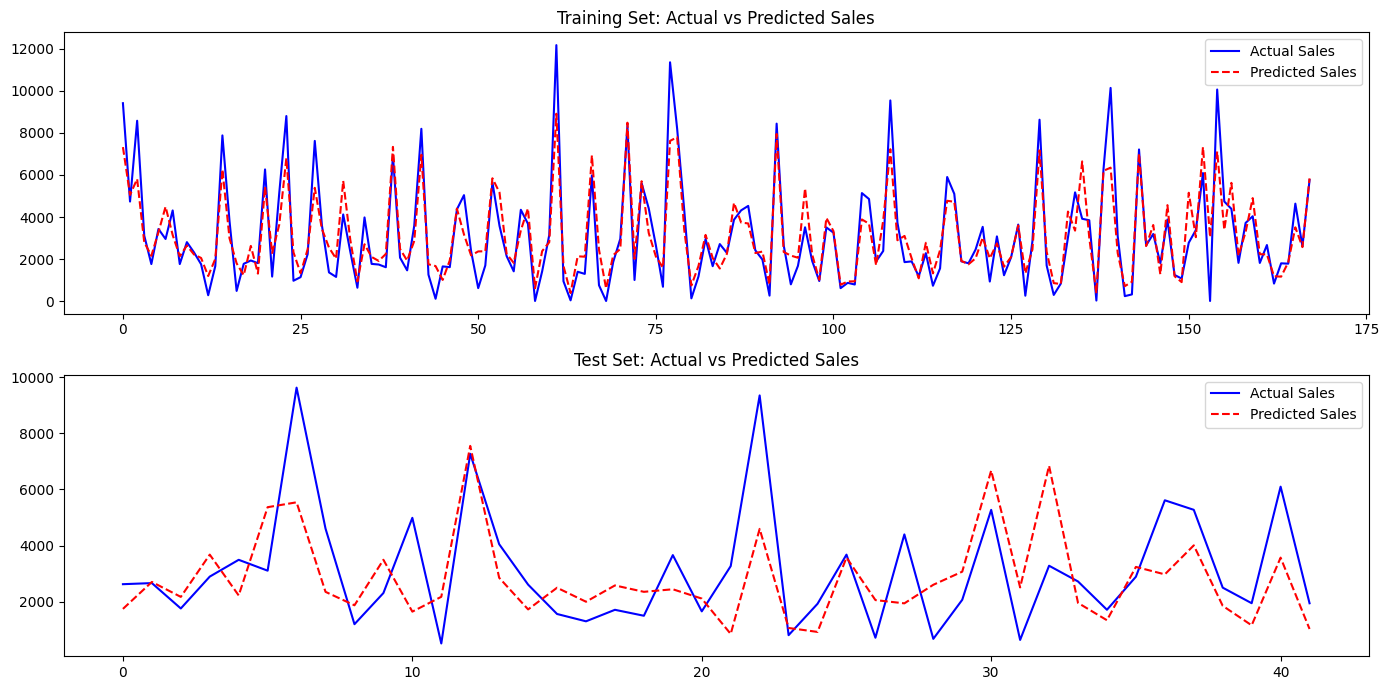

In [6]:
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(y_train.values, label='Actual Sales', color='blue')
plt.plot(train_predictions, label='Predicted Sales', color='red', linestyle='--')
plt.title('Training Set: Actual vs Predicted Sales')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(y_test.values, label='Actual Sales', color='blue')
plt.plot(test_predictions, label='Predicted Sales', color='red', linestyle='--')
plt.title('Test Set: Actual vs Predicted Sales')
plt.legend()

plt.tight_layout()
plt.show()

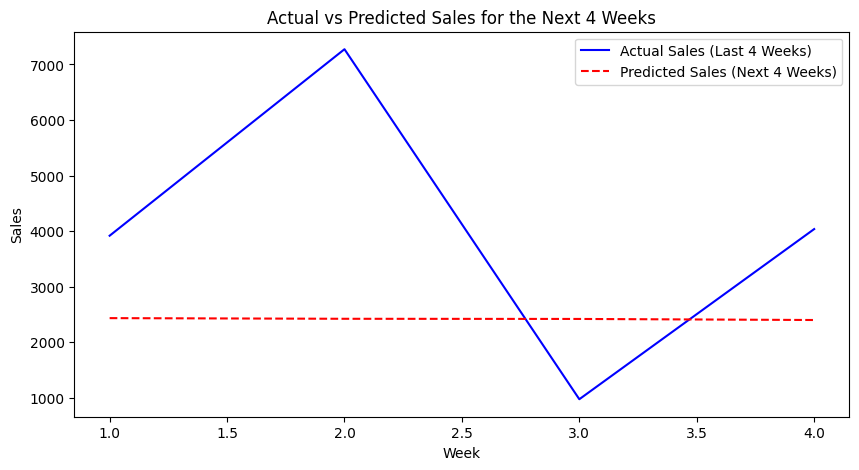

In [7]:
plt.figure(figsize=(10, 5))
actual_sales_last_4_weeks = weekly_sales['Sales'].iloc[-4:].values
weeks = np.arange(1, 5)

plt.plot(weeks, actual_sales_last_4_weeks, label='Actual Sales (Last 4 Weeks)', color='blue')
plt.plot(weeks, future_predictions, label='Predicted Sales (Next 4 Weeks)', color='red', linestyle='--')
plt.title('Actual vs Predicted Sales for the Next 4 Weeks')
plt.xlabel('Week')
plt.ylabel('Sales')
plt.legend()
plt.show()

## 5. Summary

The simplified model with a single lagged feature provided a balance between simplicity and effectiveness. The steps taken included loading and preprocessing the data, extracting relevant date features, encoding categorical variables, removing outliers, aggregating sales by week, and creating a lagged sales feature. The data was split into training and test sets, and a RandomForestRegressor model was trained using the training data. The model was evaluated using R-squared, RMSE, MAE, and SMAPE metrics on both the training and test sets, and cross-validation was performed to assess generalization. The results showed that the model explained 92% of the variance in the training data but only 27% in the test data, indicating some overfitting. The mean R² score from cross-validation was 0.47, suggesting reasonable generalization. The future sales predictions for the next four weeks were also generated.

An interesting finding was the hypothesis that the previous model might be overfitting, leading to the decision to halve the best parameters (e.g., reducing tree depth and limiting the number of features considered for splits) in an attempt to create a more generalized model. Despite these adjustments, the new model exhibited even more overfitting, as evidenced by its poorer performance on the test set compared to the training set. This counterintuitive result underscores the complexity of balancing model simplicity and performance, and highlights that simply reducing model complexity does not always equate to better generalization. The findings emphasize the need for a careful and iterative approach to hyperparameter tuning.